## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import tensorflow as tf
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tf.keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2,l1_ratio=0.001):
    input_layer = tf.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tf.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = tf.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = tf.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tf.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [128,256]
Dropout_EXP = [0.1,0.25]
l1_exp=[0.0001,1e-8]

In [13]:
results = {}
for batch in BATCH_SIZE:
    for drop in Dropout_EXP:
        for l in l1_exp:
            tf.keras.backend.clear_session()
            print(f"Experiment with L1_ratio {l} drop out ratio {drop} batch size {batch}")
            model=build_mlp(input_shape=x_train.shape[1:], l1_ratio=l, drp_ratio=drop)
            model.summary()
            optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
            model.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch, validation_data=(x_test, y_test), shuffle=True)
            
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]
            
            exp_name_tag = f"l1-{l}-drop-{drop}-batch-{batch}"
            results[exp_name_tag]={'train_loss':train_loss, "valid_loss":valid_loss, "train_acc":train_acc, "valid_acc":valid_acc}

Experiment with L1_ratio 0.0001 drop out ratio 0.1 batch size 128
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________

50000/50000 [==============================] - 15s 297us/sample - loss: 5.1684 - acc: 0.4951 - val_loss: 5.1636 - val_acc: 0.4930
Epoch 40/50
50000/50000 [==============================] - 15s 295us/sample - loss: 5.1587 - acc: 0.4952 - val_loss: 5.1556 - val_acc: 0.4958
Epoch 41/50
50000/50000 [==============================] - 15s 296us/sample - loss: 5.1459 - acc: 0.4979 - val_loss: 5.1515 - val_acc: 0.4956
Epoch 42/50
50000/50000 [==============================] - 14s 290us/sample - loss: 5.1302 - acc: 0.4993 - val_loss: 5.1341 - val_acc: 0.5000
Epoch 43/50
50000/50000 [==============================] - 14s 288us/sample - loss: 5.1184 - acc: 0.5003 - val_loss: 5.1248 - val_acc: 0.4993
Epoch 44/50
50000/50000 [==============================] - 15s 291us/sample - loss: 5.1054 - acc: 0.5007 - val_loss: 5.1147 - val_acc: 0.4990
Epoch 45/50
50000/50000 [==============================] - 15s 295us/sample - loss: 5.0921 - acc: 0.5056 - val_loss: 5.1058 - val_acc: 0.5024
Epoch 46/50
50000/

50000/50000 [==============================] - 16s 329us/sample - loss: 1.4785 - acc: 0.4750 - val_loss: 1.4492 - val_acc: 0.4824
Epoch 34/50
50000/50000 [==============================] - 16s 325us/sample - loss: 1.4685 - acc: 0.4808 - val_loss: 1.4455 - val_acc: 0.4833
Epoch 35/50
50000/50000 [==============================] - 17s 334us/sample - loss: 1.4589 - acc: 0.4825 - val_loss: 1.4387 - val_acc: 0.4888
Epoch 36/50
50000/50000 [==============================] - 18s 369us/sample - loss: 1.4551 - acc: 0.4831 - val_loss: 1.4383 - val_acc: 0.4867
Epoch 37/50
50000/50000 [==============================] - 17s 348us/sample - loss: 1.4479 - acc: 0.4846 - val_loss: 1.4395 - val_acc: 0.4859
Epoch 38/50
50000/50000 [==============================] - 15s 304us/sample - loss: 1.4423 - acc: 0.4895 - val_loss: 1.4339 - val_acc: 0.4891
Epoch 39/50
50000/50000 [==============================] - 15s 300us/sample - loss: 1.4365 - acc: 0.4900 - val_loss: 1.4278 - val_acc: 0.4952
Epoch 40/50
50000/

50000/50000 [==============================] - 18s 356us/sample - loss: 5.5362 - acc: 0.3908 - val_loss: 5.3672 - val_acc: 0.4528
Epoch 28/50
50000/50000 [==============================] - 16s 320us/sample - loss: 5.5172 - acc: 0.3930 - val_loss: 5.3590 - val_acc: 0.4500
Epoch 29/50
50000/50000 [==============================] - 17s 339us/sample - loss: 5.5057 - acc: 0.3955 - val_loss: 5.3510 - val_acc: 0.4499
Epoch 30/50
50000/50000 [==============================] - 16s 327us/sample - loss: 5.4896 - acc: 0.3989 - val_loss: 5.3421 - val_acc: 0.4530
Epoch 31/50
50000/50000 [==============================] - 17s 347us/sample - loss: 5.4745 - acc: 0.4014 - val_loss: 5.3297 - val_acc: 0.4514
Epoch 32/50
50000/50000 [==============================] - 20s 398us/sample - loss: 5.4619 - acc: 0.4017 - val_loss: 5.3121 - val_acc: 0.4555
Epoch 33/50
50000/50000 [==============================] - 15s 297us/sample - loss: 5.4503 - acc: 0.4032 - val_loss: 5.3142 - val_acc: 0.4544
Epoch 34/50
50000/

50000/50000 [==============================] - 14s 285us/sample - loss: 1.7823 - acc: 0.3640 - val_loss: 1.5905 - val_acc: 0.4388
Epoch 22/50
50000/50000 [==============================] - 14s 288us/sample - loss: 1.7676 - acc: 0.3700 - val_loss: 1.5781 - val_acc: 0.4405
Epoch 23/50
50000/50000 [==============================] - 15s 291us/sample - loss: 1.7656 - acc: 0.3751 - val_loss: 1.5709 - val_acc: 0.4487
Epoch 24/50
50000/50000 [==============================] - 15s 301us/sample - loss: 1.7567 - acc: 0.3752 - val_loss: 1.5630 - val_acc: 0.4496
Epoch 25/50
50000/50000 [==============================] - 15s 296us/sample - loss: 1.7428 - acc: 0.3809 - val_loss: 1.5638 - val_acc: 0.4473
Epoch 26/50
50000/50000 [==============================] - 16s 320us/sample - loss: 1.7349 - acc: 0.3834 - val_loss: 1.5561 - val_acc: 0.4519
Epoch 27/50
50000/50000 [==============================] - 17s 333us/sample - loss: 1.7302 - acc: 0.3825 - val_loss: 1.5559 - val_acc: 0.4465
Epoch 28/50
50000/

50000/50000 [==============================] - 10s 206us/sample - loss: 5.7345 - acc: 0.3810 - val_loss: 5.6033 - val_acc: 0.4161
Epoch 16/50
50000/50000 [==============================] - 10s 204us/sample - loss: 5.7119 - acc: 0.3861 - val_loss: 5.5901 - val_acc: 0.4253
Epoch 17/50
50000/50000 [==============================] - 11s 211us/sample - loss: 5.6961 - acc: 0.3931 - val_loss: 5.5741 - val_acc: 0.4288
Epoch 18/50
50000/50000 [==============================] - 10s 205us/sample - loss: 5.6818 - acc: 0.3940 - val_loss: 5.5647 - val_acc: 0.4292
Epoch 19/50
50000/50000 [==============================] - 10s 209us/sample - loss: 5.6655 - acc: 0.3989 - val_loss: 5.5522 - val_acc: 0.4332
Epoch 20/50
50000/50000 [==============================] - 11s 211us/sample - loss: 5.6505 - acc: 0.4016 - val_loss: 5.5434 - val_acc: 0.4346
Epoch 21/50
50000/50000 [==============================] - 11s 219us/sample - loss: 5.6354 - acc: 0.4053 - val_loss: 5.5287 - val_acc: 0.4401
Epoch 22/50
50000/

50000/50000 [==============================] - 11s 222us/sample - loss: 1.9034 - acc: 0.3460 - val_loss: 1.7280 - val_acc: 0.3878
Epoch 10/50
50000/50000 [==============================] - 11s 213us/sample - loss: 1.8741 - acc: 0.3504 - val_loss: 1.7081 - val_acc: 0.4013
Epoch 11/50
50000/50000 [==============================] - 10s 204us/sample - loss: 1.8539 - acc: 0.3594 - val_loss: 1.6970 - val_acc: 0.4020
Epoch 12/50
50000/50000 [==============================] - 8s 161us/sample - loss: 1.8327 - acc: 0.3634 - val_loss: 1.6831 - val_acc: 0.4046
Epoch 13/50
50000/50000 [==============================] - 8s 160us/sample - loss: 1.8146 - acc: 0.3695 - val_loss: 1.6667 - val_acc: 0.4123
Epoch 14/50
50000/50000 [==============================] - 8s 164us/sample - loss: 1.7982 - acc: 0.3739 - val_loss: 1.6604 - val_acc: 0.4133
Epoch 15/50
50000/50000 [==============================] - 8s 154us/sample - loss: 1.7845 - acc: 0.3775 - val_loss: 1.6466 - val_acc: 0.4176
Epoch 16/50
50000/5000

50000/50000 [==============================] - 8s 156us/sample - loss: 6.4143 - acc: 0.2088 - val_loss: 5.9551 - val_acc: 0.2985
Epoch 4/50
50000/50000 [==============================] - 8s 159us/sample - loss: 6.3277 - acc: 0.2294 - val_loss: 5.9004 - val_acc: 0.3180
Epoch 5/50
50000/50000 [==============================] - 8s 157us/sample - loss: 6.2571 - acc: 0.2438 - val_loss: 5.8804 - val_acc: 0.3250
Epoch 6/50
50000/50000 [==============================] - 8s 156us/sample - loss: 6.1985 - acc: 0.2568 - val_loss: 5.8378 - val_acc: 0.3400
Epoch 7/50
50000/50000 [==============================] - 8s 157us/sample - loss: 6.1642 - acc: 0.2649 - val_loss: 5.8166 - val_acc: 0.3443
Epoch 8/50
50000/50000 [==============================] - 8s 157us/sample - loss: 6.1327 - acc: 0.2733 - val_loss: 5.7894 - val_acc: 0.3499
Epoch 9/50
50000/50000 [==============================] - 8s 156us/sample - loss: 6.0952 - acc: 0.2771 - val_loss: 5.7819 - val_acc: 0.3573
Epoch 10/50
50000/50000 [======

Epoch 1/50
50000/50000 [==============================] - 9s 178us/sample - loss: 2.7896 - acc: 0.1383 - val_loss: 2.2192 - val_acc: 0.1648
Epoch 2/50
50000/50000 [==============================] - 8s 156us/sample - loss: 2.5362 - acc: 0.1888 - val_loss: 2.0805 - val_acc: 0.2411
Epoch 3/50
50000/50000 [==============================] - 8s 158us/sample - loss: 2.4378 - acc: 0.2135 - val_loss: 1.9795 - val_acc: 0.2938
Epoch 4/50
50000/50000 [==============================] - 8s 156us/sample - loss: 2.3379 - acc: 0.2350 - val_loss: 1.9334 - val_acc: 0.3131
Epoch 5/50
50000/50000 [==============================] - 8s 157us/sample - loss: 2.2877 - acc: 0.2459 - val_loss: 1.8917 - val_acc: 0.3329
Epoch 6/50
50000/50000 [==============================] - 8s 156us/sample - loss: 2.2366 - acc: 0.2589 - val_loss: 1.8781 - val_acc: 0.3370
Epoch 7/50
50000/50000 [==============================] - 8s 156us/sample - loss: 2.1967 - acc: 0.2641 - val_loss: 1.8488 - val_acc: 0.3484
Epoch 8/50
50000/500

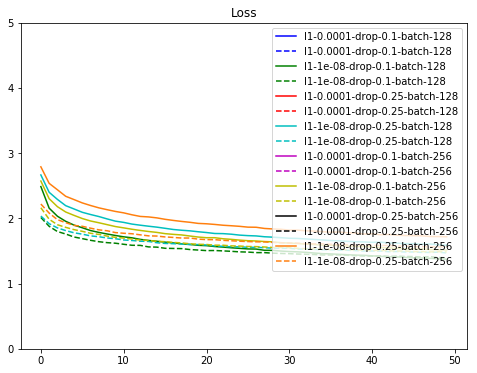

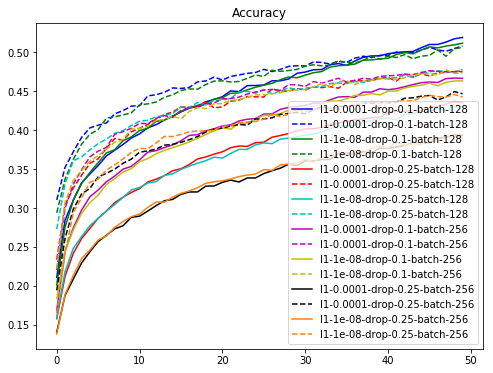

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'C1']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()